# Assignment 2: Itaconic acid production (part 1)

<img src="Ita_model.png" width="800" />

Firstly, import all the necessary libraries:

In [79]:
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import odeint
from matplotlib import pyplot as plt

Now specify constants and known values. Beta is determined. CO$_{2}$ mass transfer coefficient is determined.

In [80]:
alpha = 0.1
gamma = 2.5
mumax = 0.05
thetamax = 0.05
PO = 1.5

Km = 0.001

def beta(beta):
    nul1 = (1 + alpha)*4 - ((4 + 1*1.8 - 2*0.5 - 3*0.2) + 2*beta)
    return nul1
beta = fsolve(beta, alpha)[0]

tmax = 150
cS0 = 20
cX0 = 0.05

kLa = 200 # 1/h
cOsatmax = 7/1000/32  #mol/l

The metabolic flux matrix is set up.

In [81]:
Sflux = np.matrix([[-1, 1 + alpha, 1,   1,   0,    0,    0],
                   [0,  0,         0,   -1,  3/2,  1.2,  0],
                   [0,  beta,      2,   1/3, -1/2, 1/5,  -2],
                   [0,  -gamma,    1/2, 1/3, 0,    -1/5, 2*PO]])
#                   rS, rX,        r2,  r3,  rEt,  rIta, rO
#                   r[0]r[1]                 r[4]  r[5]  r[6]
Et_spec = [0, 0, 0, 0, 1, 0, 0]
O_spec = [0, 0, 0, 0, 0, 0, 1]
resp_spec = [0, 0, 1, 0, 0, 0, 0]
Ita_spec = [0, 0, 0, 0, 0, 1, 0]
mu_spec = [0, 1, 0, 0, 0, 0, 0]
S_spec = [1, 0, 0, 0, 0, 0, 0]

Specifications are chosen for the scenarios we are working with.

In [82]:
S1 = np.vstack([Sflux, mu_spec, Et_spec, Ita_spec])
S2 = np.vstack([Sflux, S_spec, Et_spec, O_spec])

The rate function is written.

In [83]:
def Meta(var):
    cS, cX = var
    
    mu = mumax*(cS/(Km + cS))
    theta = thetamax*(cS/(Km + cS))
    
    rOmt = kLa*cOsatmax
    
    C1 = np.array([0, 0, 0, theta, mu, 0, 0]).T
    r1 = np.linalg.solve(S1, C1)
    
    lamb = r1[0]
    
    C2 = np.array([0, 0, 0, theta, lamb, 0, rOmt/cX]).T
    r2 = np.linalg.solve(S2, C2)
    
    if rOmt > r1[6]*cX:
        return r1
    else:
        return r2

The fermenter function is written.

In [84]:
def Batch(var, t):
    cS, cX, cE, cI = var
    
    dcSdt = -Meta([cS, cX])[0]*cX
    dcXdt = Meta([cS, cX])[1]*cX
    dcEdt = Meta([cS, cX])[4]*cX
    dcIdt = Meta([cS, cX])[5]*cX
    
    return [dcSdt, dcXdt, dcEdt, dcIdt]

Integrated.

In [85]:
tspan = np.linspace(0, tmax, 101)
c_0 = np.array([cS0, cX0, 0, 0])
c = odeint(Batch, c_0, tspan, mxstep=50000)
cS = c[:,0]
cX = c[:,1]
cE = c[:,2]
cI = c[:,3]

Concentration profiles are plotted.

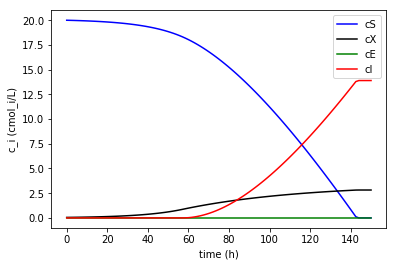

In [86]:
plt.figure(1)
plt.plot(tspan, cS, 'b', label = 'cS')
plt.plot(tspan, cX, 'k', label = 'cX')
plt.plot(tspan, cE, 'g', label = 'cE')
plt.plot(tspan, cI, 'r', label = 'cI')
plt.legend(loc = 'best')
plt.xlabel('time (h)')
plt.ylabel('c_i (cmol_i/L)')
plt.savefig('c_profile.png', dpi = 300)
plt.show()

Gas rates are determined.

In [88]:
rOlist = []
rClist = []
mulist = []

for i in range(len(cX)):
    mu = mumax*(cS[i]/(Km + cS[i]))
#     mulist.append(mu)
    theta = thetamax*(cS[i]/(Km + cS[i]))
    rOmt = kLa*cOsatmax
    C1 = np.array([0, 0, 0, theta, mu, 0, 0]).T
    r1 = np.linalg.solve(S1, C1)
    rO1 = r1[6]*cX[i]
    rC1 = (alpha*r1[1] + r1[2] + 1/2*r1[4] + 1/5*r1[5])*cX[i]
    
    lamb = r1[0]
    
    C2 = np.array([0, 0, 0, theta, lamb, 0, rOmt/cX[i]]).T
    r2 = np.linalg.solve(S2, C2)
    rO2 = r2[6]*cX[i]
    rC2 = (alpha*r2[1] + r2[2] + 1/2*r2[4] + 1/5*r2[5])*cX[i]

    if rOmt > r1[6]*cX[i]:
        rOlist.append(rO1)
        rClist.append(rC1)
        mulist.append(r1[1])
    else:
        rOlist.append(rO2)
        rClist.append(rC2)
        mulist.append(r2[1])
        
rO = np.array(rOlist)
rC = np.array(rClist)
mu = np.array(mulist)

Gas rates are plotted.

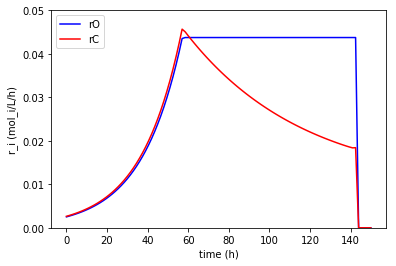

In [89]:
plt.figure(2)
plt.plot(tspan, rO, 'b', label = 'rO')
plt.plot(tspan, rC, 'r', label = 'rC')
plt.ylim([0.00, 0.05])
plt.legend(loc = 'best')
plt.xlabel('time (h)')
plt.ylabel('r_i (mol_i/L/h)')
plt.savefig('rO2_rCO2.png', dpi = 300)
plt.show()

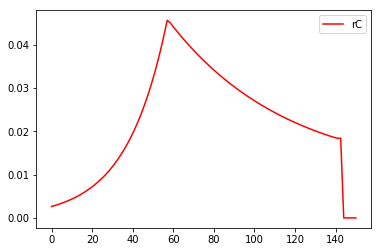

In [90]:
plt.figure(3)
plt.plot(tspan, rC, 'r', label = 'rC')
# plt.ylim([0.03, 0.032])
plt.legend(loc = 'best')
plt.show()

$\mu$ is plotted per time unit.

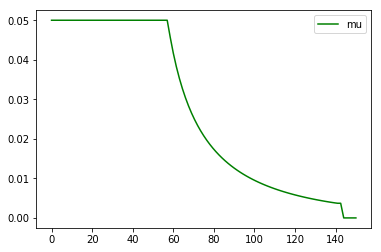

In [91]:
plt.figure(4)
plt.plot(tspan, mu, 'g', label = 'mu')
# plt.ylim([0.03, 0.032])
plt.legend(loc = 'best')
plt.show()

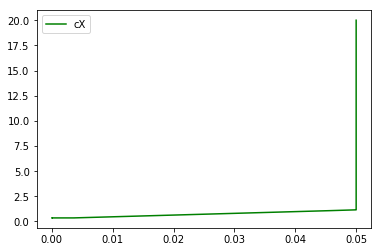

In [92]:
plt.figure(5)
plt.plot(mu, 1/cX, 'g', label = 'cX')
# plt.ylim([0.03, 0.032])
plt.legend(loc = 'best')
plt.show()

$r_{O_{2}}$ is plotted as a function of $\mu$.

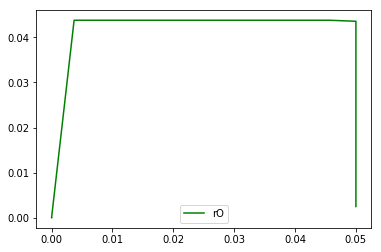

In [93]:
plt.figure(6)
plt.plot(mu, rO, 'g', label = 'rO')
# plt.ylim([0.03, 0.032])
plt.legend(loc = 'best')
plt.show()